# Importing data and libraries

In [482]:
import numpy as np 
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time

In [483]:
df_news = pd.read_excel('/Users/selim/Desktop/MA1/ML/Local tests/Sentiment Analysis/sentiment_analysis.xlsx')

In [484]:
df_stocks = pd.read_excel('/Users/selim/Desktop/MA1/ML/Local tests/Stock Prediction/stocks_all_78.xlsx')

Remark: Change file paths according to your directories to assure smooth code execution 

# Preparing the dataframes

### News dataframe

In [ ]:
# Choosing the company
COMPANY = 'HSBC'

In [485]:
# Function that returns the flair polarity
df_news['flair polarity'] = df_news.apply(lambda row: (row['flair confidence']*-1
                                                        if row['flair sentiment'] == 'NEGATIVE'
                                                        else row['flair confidence']), axis=1)

In [486]:
# Dropping the articles and sources from the news dataframe
df_news = df_news[['date', 'company', 'flair polarity']]

In [487]:
# Function that casts dates to datetime type in order to do comparaisons 
def clean(date):
    date = re.sub('[^0-9-]+', '', date)
    return datetime.strptime(date, '%Y-%m-%d')

In [488]:
df_news['date'] = df_news['date'].apply(clean)

In [ ]:
# Keeping only articles written after 2011 as we only look at stocks strating from 2011
df_news = df_news[df_news['date'] > datetime(2010, 12, 31)].sort_values(by='date', ascending=True)

In [ ]:
# Keeping only rows of the company to predict
df_news_company = df_news[df_news['company'] == COMPANY]

### Stocks dataframe

In [493]:
# Keeping only Closing price and Volume, keeping stocks starting from 2011
df_stocks = df_stocks[df_stocks['Date'] > datetime(2010, 12, 31)].drop(columns=['High', 'Low', 'Open', 'Adj Close']).sort_values(by='Date', ascending=True)

In [ ]:
# Isolating the company to predict
df_stocks_company = df_stocks[df_stocks['company_name'] == COMPANY]

### Merging 

In [495]:
# Function that gets cumulative polarity of the company up to a given date
def get_cumul(date):
    df_date = df_news_company[df_news_company['date'] < date]
    array = df_date['flair polarity'].values
    sum = np.sum(array)
    avg = sum / len(array)
    return avg

In [ ]:
df_stocks_company['cumulative polarity'] = df_stocks_company['Date'].apply(get_cumul)

In [497]:
# Stocks start earlier than articles so we fill with a cumulative polarity of 0 (neutral)
df_stocks_company = df_stocks_company.fillna(0)

In [498]:
df_stocks_company = df_stocks_company.set_index('Date').drop(columns=['company_name'])

# Predicting stocks with news

### Preparing training, validation and test sets

In [500]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [501]:
# # Mapping the stocks to the [0,1] interval
data = sc.fit_transform(df_stocks_company)

In [502]:
# Using 95% of data for training, 2.5% for validation and 2.5% for testing
train_ind = int(0.95*len(df_stocks_company))
val_ind = train_ind + int(0.025*len(df_stocks_company))
train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

In [503]:
xtrain,ytrain,xval,yval,xtest,ytest = train[:,:],train[:,0],val[:,:],val[:,0],test[:,:],test[:,0]
xtrain.shape, ytrain.shape, 

((2391, 3), (2391,))

In [504]:
# Set the lookback to 20 days and specifying the number of feature (Close, Volume and cumulative polarity)
lookback = 20
n_features = 3
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

In [505]:
# Building the training set
x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (2371, 20, 3)
y_train (2371,)


In [506]:
# Building the validation set
x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

x_val (42, 20, 3)
y_val (42,)


In [507]:
# Building the test set 
x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (44, 20, 3)
y_test (44,)


### Training the model

In [508]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping

In [509]:
# Building a model with 2 LTSM layers and 1 dense layer
model = Sequential() 
model.add(LSTM(110,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(110))
model.add(Dense(1))

In [510]:
# Using mse as loss function and adam as optimizer and earlystop to avoid overfitting on the validation set
model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [ ]:
# Training the model
start = time()
print("start:",0)
model.fit(x_train,y_train, epochs = 2, batch_size=40, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

In [512]:
y_pred = model.predict(x_test)

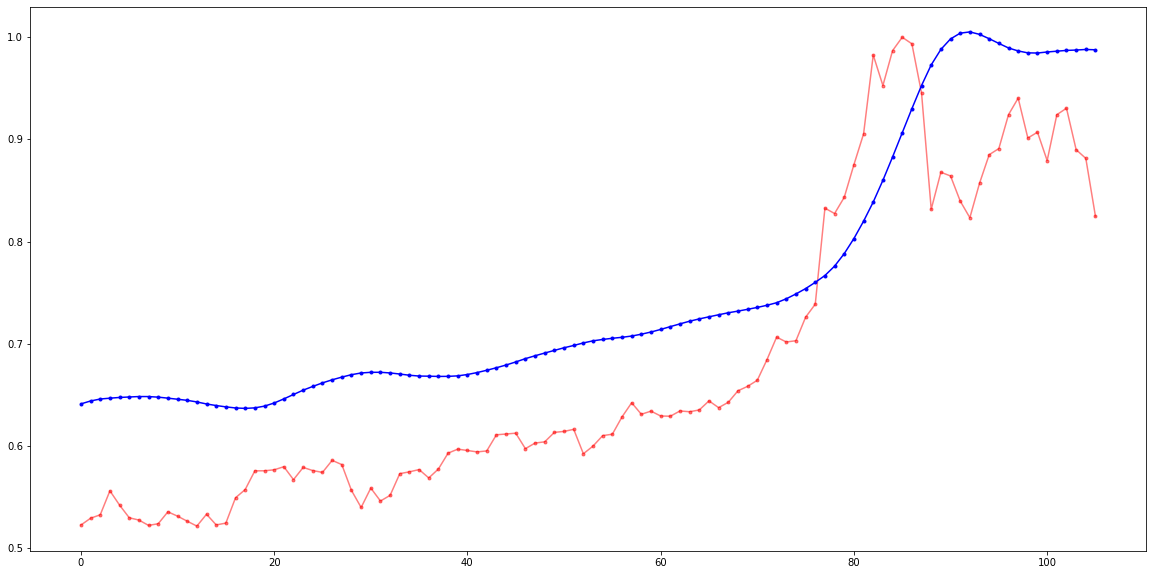

In [450]:
# Plotting the prediction against the true stock values
plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)

### Inverse transform

In [514]:
# Tranforming the prediction back to the original stock values
data[-len(y_pred):, 0] = y_pred[:, 0]
predictions = sc.inverse_transform(data)

In [515]:
y_stock_pred = predictions[-len(y_pred):, 0]
y_stock_true = df_stocks_company['Close'].values[-len(y_pred):]

### Computing MAPE

In [516]:
# We compute the accuracy using the MAPE rule
def mape(prediction, test):
    return np.mean(np.abs((test - prediction) / test)) * 100

In [517]:
print('MAPE =', mape(y_stock_pred, y_stock_true), '%')

MAPE = 5.176189711764565 %
